In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, PandasTools, MACCSkeys, rdFingerprintGenerator
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

from pathlib import Path
from warnings import filterwarnings
import time
import math
import gzip


from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

import io
import requests
from biopandas.pdb import PandasPdb
import nglview


In [ ]:
active3 = pd.read_csv('active3.csv')
smi_ligand = active3.iloc[0]['SMILES']

smi_mol = Chem.MolFromSmiles(smi_ligand)
smi_mol =  Chem.AddHs(smi_mol)
AllChem.EmbedMolecule(smi_mol, AllChem.ETKDG())



# 3. Write the molecule to an SDF file
sdf_writer = Chem.SDWriter("output.sdf")  # Replace "output.sdf" with your desired file name

# Write the molecule to the SDF file
sdf_writer.write(smi_mol)

In [ ]:
def submit_dogsitescorer_job_with_pdbid(pdb_code, chain_id, ligand=""):
    """
    Submit PDB ID to DoGSiteScorer webserver using their API and get back URL for job location.

    Parameters
    ----------
    pdb_code : str
        4-letter valid PDB ID, e.g. '3w32'.
    chain_id : str
        Chain ID, e.g. 'A'.
    ligand : str
        Name of ligand bound to PDB structure with pdb_id, e.g. 'W32_A_1101'.
        Currently, the ligand name must be checked manually on the DoGSiteScorer website.

    Returns
    -------
    str
        Job location URL for submitted query.

    References
    ----------
    Function is adapted from: https://github.com/volkamerlab/TeachOpenCADD/pull/3 (@jaimergp)
    """

    # Submit job to proteins.plus
    # For details on parameters see: https://proteins.plus/help/dogsite_rest
    r = requests.post(
        "https://proteins.plus/api/dogsite_rest",
        json={
            "dogsite": {
                "pdbCode": pdb_code,  # PDB code of protein
                "analysisDetail": "1",  # 1 = include subpockets in results
                "bindingSitePredictionGranularity": "1",  # 1 = include drugablity scores
                "ligand": ligand,  # if name is specified, ligand coverage is calculated
                "chain": chain_id,  # if chain is specified, calculation is only performed on this chain
            }
        },
        headers={"Content-type": "application/json", "Accept": "application/json"},
    )


    r.raise_for_status()

    return r.json()["location"]

In [ ]:
pdb_id = "8F7Q"
chain_id = "A"
# Ligand id manually looked-up from DoGSiteScorer within proteins.plus
# Note that it is generally composed of [pdb_lig_id]_[chain_id]_[pdb_residue_id]
ligand_id = "CLR_M_401"

In [ ]:
job_location = submit_dogsitescorer_job_with_pdbid(pdb_id, chain_id, ligand_id)
job_location

'https://proteins.plus/api/dogsite_rest/H2JtC5SGkm4QDQfnnWE1TSzj'

In [ ]:
def get_dogsitescorer_metadata(job_location, attempts=30):
    """
    Get results from a DoGSiteScorer query, i.e., the binding sites which are found over the protein surface,
    in the form of a table with the details about all detected pockets.

    Parameters
    ----------
    job_location : str
        Consists of the location of a finished DoGSiteScorer job on the proteins.plus web server.
    attempts : int
        The time waiting for the feedback from DoGSiteScorer service.

    Returns
    -------
    pandas.DataFrame
        Table with metadata on detected binding sites.
    """

    print(f"Querying for job at URL {job_location}...", end="")

    while attempts:
        # Get job results
        result = requests.get(job_location)
        result.raise_for_status()
        # Get URL of result table file
        response = result.json()
        if "result_table" in response:
            result_file = response["result_table"]
            break
        attempts -= 1
        print(".", end="")
        time.sleep(10)
    # Get result table (as string)
    result_table = requests.get(result_file).text
    # Load the table (csv format using "\t" as separator) with pandas DataFrame
    # We cannot load the table from a string directly but from a file
    # Use io.StringIO to wrap this string as file-like object as needed for read_csv method
    # See more: https://docs.python.org/3/library/io.html#io.StringIO
    result_table_df = pd.read_csv(io.StringIO(result_table), sep="\t").set_index("name")

    return result_table_df

In [ ]:
metadata = get_dogsitescorer_metadata(job_location)
metadata.head()

Querying for job at URL https://proteins.plus/api/dogsite_rest/H2JtC5SGkm4QDQfnnWE1TSzj...

,lig_cov,poc_cov,lig_name,volume,enclosure,surface,depth,surf/vol,lid/hull,ellVol,...,MET,PHE,PRO,SER,THR,TRP,TYR,VAL,simpleScore,drugScore
name,,,,,,,,,,,,,,,,,,,,,
P_0,0.0,0.0,CLR_M_401,859.58,0.13,1375.57,18.44,1.600282,-,-,...,2,6,0,3,6,0,0,5,0.55,0.812186
P_0_0,0.0,0.0,CLR_M_401,287.10,0.13,559.78,15.16,1.949774,-,-,...,0,0,0,2,2,0,0,0,0.27,0.131748
P_0_1,0.0,0.0,CLR_M_401,179.26,0.22,373.97,9.84,2.086188,-,-,...,1,2,0,0,2,0,0,1,0.12,0.236280
P_0_2,0.0,0.0,CLR_M_401,91.39,0.32,260.20,6.31,2.847139,-,-,...,0,0,0,1,1,0,0,2,0.00,0.237285
P_0_3,0.0,0.0,CLR_M_401,82.37,0.00,233.34,0.00,2.832827,-,-,...,2,2,0,0,1,0,0,2,0.00,0.283985


In [ ]:
metadata = metadata[
    [
        "lig_name",
        "volume",
        "enclosure",
        "surface",
        "depth",
        "surf/vol",
        "accept",
        "donor",
        "hydrophobic_interactions",
        "hydrophobicity",
        "metal",
        "simpleScore",
        "drugScore",
    ]
]


metadata = metadata.sort_values(by='drugScore', ascending=False)

metadata

,lig_name,volume,enclosure,surface,depth,surf/vol,accept,donor,hydrophobic_interactions,hydrophobicity,metal,simpleScore,drugScore
name,,,,,,,,,,,,,
P_0,CLR_M_401,859.58,0.13,1375.57,18.44,1.600282,70,20,51,0.36,0,0.55,0.812186
P_1,CLR_M_401,518.14,0.18,784.53,15.23,1.514127,24,17,30,0.42,0,0.34,0.737766
P_0_4,CLR_M_401,75.78,0.00,92.03,2.71,1.214437,3,1,4,0.50,0,0.00,0.677076
P_3,CLR_M_401,382.40,0.10,739.96,14.03,1.935042,36,11,27,0.36,0,0.21,0.649719
P_2,CLR_M_401,401.98,0.15,493.62,11.48,1.227972,36,13,7,0.12,0,0.13,0.573229
P_0_7,CLR_M_401,44.10,0.00,58.10,1.26,1.317460,4,1,0,0.00,0,0.00,0.553212
P_4,CLR_M_401,179.52,0.05,419.28,12.82,2.335561,28,10,21,0.36,0,0.00,0.443365
P_1_0,CLR_M_401,288.00,0.17,520.41,15.23,1.806979,12,11,22,0.49,0,0.29,0.438806
P_1_1,CLR_M_401,230.14,0.20,338.39,11.90,1.470366,12,7,9,0.32,0,0.19,0.362802


In [ ]:
def select_best_pocket(metadata, sorted_by="drugScore"):
    """
    This function uses the defined sorting parameter to identify
    the best pocket among the obtained pockets.

    Parameters
    ----------
    metadata : pd.DataFrame
        Pockets retrieved from the DoGSiteScorer website

    by : str
        Method name(s) to sort table by (default is to sort by drugScore).

    Returns
    -------
    str
        Best binding site name.
    """

    by_methods = ["drugScore", "volume", "simpleScore", "lig_cov", "poc_cov"]

    # Sort by the selected method
    if all(elem in by_methods for elem in sorted_by):
        sorted_pocket = metadata.sort_values(sorted_by, ascending=False)
    else:
        raise ValueError(f'Selection method not in list: {", ".join(by_methods)}')

    # Get name of best pocket
    best_pocket_name = sorted_pocket.iloc[0, :].name

    return best_pocket_name

In [ ]:
best_pocket_id = select_best_pocket(metadata, ["drugScore"])
best_pocket_id


'P_0'

In [ ]:
def get_url_for_pockets(job_location, file_type="pdb"):
    """
    Get all pocket file locations for a finished DoGSiteScorer job
    for a selected file type (pdb/ccp4).

    Parameters
    ----------
    job_location : str
        URL of finished job submitted to the DoGSiteScorer web server.
    file_type : str
        Type of file to be returned (pdb/ccp4).

    Returns
    -------
    list
        List of all respective pocket file URLs.
    """

    # Get job results
    result = requests.get(job_location)

    if file_type == "pdb":
        # Get pocket residues
        return result.json()["residues"]
    elif file_type == "ccp4":
        # Get pocket volumes
        return result.json()["pockets"]
    else:
        raise ValueError(f"File type {file_type} not available.")

In [ ]:
def get_selected_pocket_location(job_location, best_pocket, file_type="pdb"):
    """
    Get the selected binding site file location.

    Parameters
    ----------
    job_location : str
        URL of finished job submitted to the DoGSiteScorer web server.
    best_pocket : str
        Selected pocket id.
    file_type : str
        Type of file to be returned (pdb/ccp4).

    Returns
    ------
    str
        URL of selected pocket file on the DoGSiteScorer web server.
    """
    result = []

    # Get URL for all available pdb or ccp4 files
    pocket_files = get_url_for_pockets(job_location, file_type)

    for pocket_file in pocket_files:
        if file_type == "pdb":
            if f"{best_pocket}_res" in pocket_file:
                result.append(pocket_file)
        elif file_type == "ccp4":
            if f"{best_pocket}_gpsAll" in pocket_file:
                result.append(pocket_file)

    if len(result) > 1:
        raise TypeError(f'Multiple strings detected: {", ".join(result)}.')
    elif len(result) == 0:
        raise TypeError(f"No string detected.")
    else:
        pass

    return result[0]

In [ ]:
selected_pocket_residues_url = get_selected_pocket_location(job_location, best_pocket_id, "pdb")
selected_pocket_residues_url

'https://proteins.plus/results/dogsite/H2JtC5SGkm4QDQfnnWE1TSzj/8f7q_P_0_res.pdb'

In [ ]:
metadata.loc[best_pocket_id]
# NBVAL_CHECK_OUTPUT

lig_name                    CLR_M_401
volume                         859.58
enclosure                        0.13
surface                       1375.57
depth                           18.44
surf/vol                     1.600282
accept                             70
donor                              20
hydrophobic_interactions           51
hydrophobicity                   0.36
metal                               0
simpleScore                      0.55
drugScore                    0.812186
Name: P_0, dtype: object

In [ ]:
selected_pocket_volume_url = get_selected_pocket_location(job_location, best_pocket_id, "ccp4")
selected_pocket_volume_url

'https://proteins.plus/results/dogsite/H2JtC5SGkm4QDQfnnWE1TSzj/8f7q_P_0_gpsAll.ccp4.gz'

In [ ]:
r = requests.get(selected_pocket_volume_url)
r.raise_for_status()
# Decompress response content and wrap it in a file-like object
memfile = io.BytesIO(gzip.decompress(r.content))

In [ ]:
viewer = nglview.show_pdbid(pdb_id)
# Since we are passing bytes with no path or extension
# we need to tell nglview what kind of data this is: ccp4
viewer.add_component(memfile, ext="ccp4")
viewer.center()
viewer

NGLWidget()

In [ ]:
viewer.render_image(trim=True, factor=2);

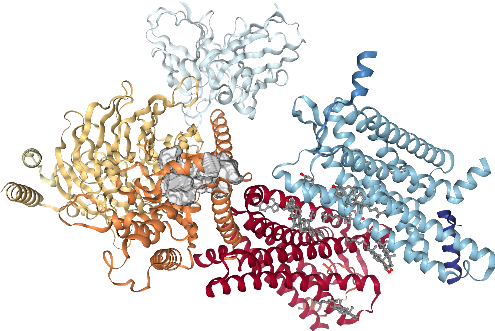

In [ ]:
viewer._display_image()